# Home Credit Default Risk

This project is about the prediction of the capability of applicants to repay a loan. The dataset contains following files:
    
    - Train/Test data: main  data, contain information about each loan application at Home Credit
    - Bureau: information about client's previous credits from other financial institutions
    - Bureau balance: monthly data about the previous credits in bureau
    - Credit card balance: monthly data about previous credit cards clients have had with Home Credit
    - Installments payments: payment history for previous loans at Home Credit
    - POS_CASH balance: monthly data about previous point of sale or cash loans clients have had with Home Credit
    - Previous application: previous applications for loans at Home Credit of clients who have loans in the application data
    

In [1]:
# Import libraries
import os

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load train and test data
traindata = pd.read_csv('D:/Python/Incubator_challenge/Home credit default risk/application_train.csv')
testdata = pd.read_csv('D:/Python/Incubator_challenge/Home credit default risk/application_test.csv')
traindata.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


# Exploratory data analysis for main data

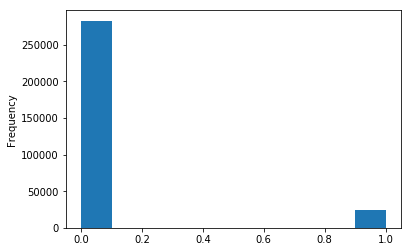

In [3]:
# Let's take a look at the distribution of the target column. We can see that this is an imbalanced class problem.

traindata['TARGET'].astype(int).plot.hist();

We can see that this is a imbalanced classification problem, i.e. there are far more loans that were repaid on time (target=0) than loans that were not repaid on time (target=1). To deal with such kind of problems, possible strategies include:
- Metric selection: Since we care more about the prediction accuracy on loans not repaid (target=1), FN (TP) rate should be selected as metrics for our models
- Undersampling the majority class (loans that were repaid)/Oversampling the minority class (loans that were not repaid)/hyrid of oversampling and undersampling
- Cost function modification: assign different cost functions to false negative and false positive

In [4]:
# checking missing data for the training data
missing_values = traindata.isnull().sum().sort_values(ascending = False)
percentage = (traindata.isnull().sum()/traindata.isnull().count()*100).sort_values(ascending = False)
missing_traindata  = pd.concat([missing_values, percentage], axis=1, keys=['missing_values', 'percentage'])
missing_traindata.head(10)

,missing_values,percentage
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_MODE,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953


We might need to drop the columns with a high percentage of missing values (a threshould need to be decided). For the rest of the missing values, we need to fill in these values.

In [24]:
# Start exploratory data analysis

def plot_function(feature,label_rotation=False):

    targetpercent = traindata[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    targetpercent.sort_values(by='TARGET', ascending=False, inplace=True)
         
    s = sns.barplot( x = feature, y='TARGET', order=targetpercent[feature], data=targetpercent)   
    
    s.set_xticklabels(s.get_xticklabels(),rotation=90)  
    plt.ylabel('Percent of target with value 1', fontsize=10)
    plt.xlabel(feature, fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.show();

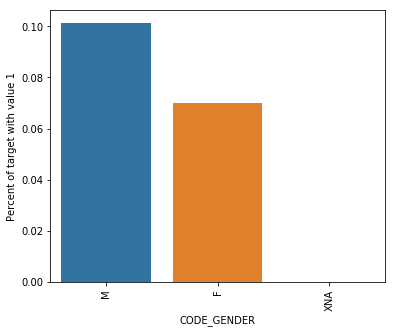

In [25]:
# Effect of gender on the percentage with target value 1 (loans not repaid)

plt.figure(figsize=[6,5])   
plot_function('CODE_GENDER')

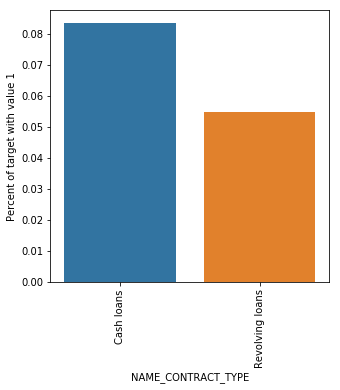

In [26]:
# Effect of contract type on the percentage with target value 1 (loans not repaid)
plt.figure(figsize=[5,5])   
plot_function('NAME_CONTRACT_TYPE')

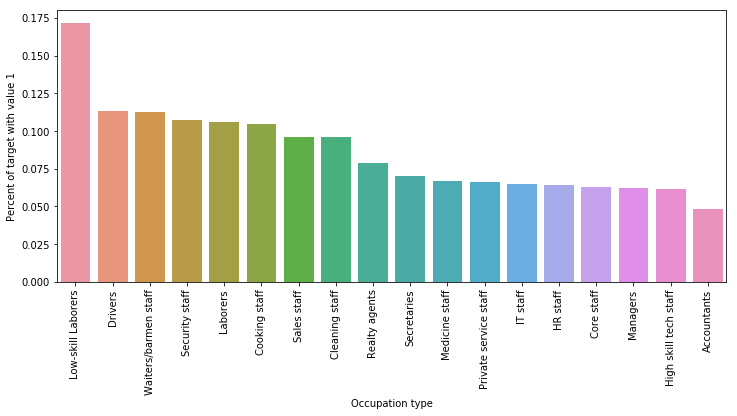

In [8]:
# Effect occupation of the applicants on the percentage with target value 1 (loans not repaid)
plt.figure(figsize=[12,5])   
plot_function('OCCUPATION_TYPE')

It seems like:
    - Male clients are most likely to default on their loans
    - Clients who use cash loans are most likely to default on their loans
    - Clients with an occupation of low-skilled laborers are most likely to default on their loans.

In [9]:
#We deal with categorical variables by one-hot encoding

traindata1 = pd.get_dummies(traindata, drop_first=True)
print(traindata1.shape)

(307511, 230)


One way to understand our data is by looking for correlations between the features and the target. We can calculate the Pearson correlation coefficient between every variable and the target.

In [10]:
# Calculate the Pearson correlation coefficients bewteen features and target

X = traindata1.drop(['SK_ID_CURR','TARGET'],axis = 1)
y = traindata1.TARGET

cor_list = []
for i in X.columns.tolist():
    cor = np.corrcoef(X[i], y)[0, 1]
    cor_list.append(cor)

# replace NaN with 0
cor_list = [0 if np.isnan(i) else i for i in cor_list]

num = np.array(X.columns.tolist() + cor_list)
reshaped = num.reshape(2,228).transpose()
table = pd.DataFrame(reshaped,columns = ['Feature','Cor_eff'])
table.sort_values(by='Cor_eff', ascending=False, inplace=True)
table.Cor_eff = pd.to_numeric(table.Cor_eff)

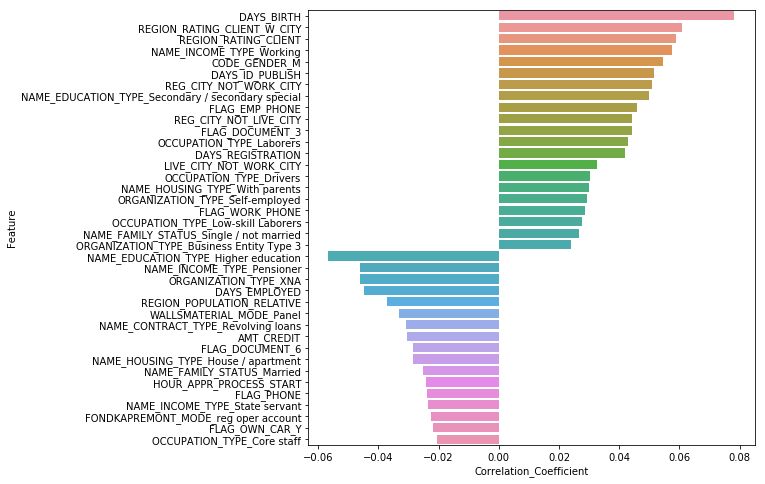

In [11]:
### Plot the correlation coefficient for values larger than 0.02
table = table.loc[abs(table['Cor_eff']) > 0.02]

plt.figure(figsize=[8,8])   
sns.set_color_codes('pastel')

s = sns.barplot(x ='Cor_eff', y='Feature', data=table, orient = 'h')   
#s.set_xticklabels(s.get_yticklabels())  
#s.set_yticklabels(s.get_yticklabels(), rotation=2, ha="right")
plt.ylabel('Feature', fontsize=10)
plt.xlabel('Correlation_Coefficient', fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show();

It seems like the DAYS_BIRTH feature has the most positive correlation weith the target. Since the values of DAYS_BIRTH are in negative, this means that clients that are older are less likely to default on their loan.

# Other sources of data
In order to achieve a high accuracy of this model, we would need to introduce more features. Threfore, the rest of the data need to be imported. The plan here is to introduce as many feature as possible first and then conduct feature selection.

In [12]:
# Read in the rest of the data
POS_CASH_balance = pd.read_csv('D:/Python/Incubator_challenge/Home credit default risk/POS_CASH_balance.csv')
bureau_balance = pd.read_csv('D:/Python/Incubator_challenge/Home credit default risk/bureau_balance.csv')
previous_application = pd.read_csv('D:/Python/Incubator_challenge/Home credit default risk/previous_application.csv')
installments_payments = pd.read_csv('D:/Python/Incubator_challenge/Home credit default risk/installments_payments.csv')
credit_card_balance = pd.read_csv('D:/Python/Incubator_challenge/Home credit default risk/credit_card_balance.csv')
bureau = pd.read_csv('D:/Python/Incubator_challenge/Home credit default risk/bureau.csv')

In [13]:
print('Size of train data', traindata.shape)
print('Size of test data', testdata.shape)
print('Size of bureau data', bureau.shape)
print('Size of bureau_balance data', bureau_balance.shape)
print('Size of POS_CASH_balance data', POS_CASH_balance.shape)
print('Size of previous_application data', previous_application.shape)
print('Size of installments_payments data', installments_payments.shape)
print('Size of credit_card_balance data', credit_card_balance.shape)

Size of train data (307511, 122)
Size of test data (48744, 121)
Size of bureau data (1716428, 17)
Size of bureau_balance data (27299925, 3)
Size of POS_CASH_balance data (10001358, 8)
Size of previous_application data (1670214, 37)
Size of installments_payments data (13605401, 8)
Size of credit_card_balance data (3840312, 23)


# Future plans
1. Conduct data cleaning and feature engineering for all data and introduce as many features as possible.
    - Drop columns with missing data percentage over a threshould value
    - Fill in missing data
    - Check for anomalies
2. Conduct feature selection/dimensinalytity reduction. Possible approaches include:
    - Remove colinear features
    - Keep only the most relevant features (Pearson correlation coefficient, Feature importance)
    - Domain knowledge
    - PCA: projects the original set of features onto a lower dimension, in the process, eliminating any pysical representation behind the features.
3. Model selection - Gradient Boost Machine (top performance model, extremely effective on structured data)
    - An ensembe method that works by training many individual learners, most oftenly decision trees. The trees are trained sequentially with each tree learning from the mistakes of the previous ones. Hundres/thousands of weak learners are combined to make a single strong ensemble learner. The contributions of the individual trees learned during training using Gradient Descent.
    - Highly dependent on hyperparameter choices
4. Hyperparameters tuning